In [1]:
import graphlab
from __future__ import division
import numpy as np
graphlab.canvas.set_target('ipynb')

In [5]:
products = graphlab.SFrame('amazon_baby.gl/')

In [10]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

# Remove punctuation.
products['review_clean'] = products['review'].apply(remove_punctuation)

# Drop neutral sentiment reviews.
products = products[products['rating'] != 3]

# Positive sentiment to +1 and negative sentiment to -1
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [11]:
products.head()

name,review,rating,sentiment,review_clean
Planetwise Wipe Pouch,it came early and was notdisappointed. i love ...,5.0,1,it came early and was notdisappointed i love ...
Annas Dream Full Quiltwith 2 Shams ...,Very soft and comfortableand warmer than it ...,5.0,1,Very soft and comfortableand warmer than it ...
Stop Pacifier Suckingwithout tears with ...,This is a product wellworth the purchase. I ...,5.0,1,This is a product wellworth the purchase I ...
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,1,All of my kids have criednonstop when I tried to ...
Stop Pacifier Suckingwithout tears with ...,"When the Binky Fairy cameto our house, we didn't ...",5.0,1,When the Binky Fairy cameto our house we didnt ...
A Tale of Baby's Dayswith Peter Rabbit ...,"Lovely book, it's boundtightly so you may no ...",4.0,1,Lovely book its boundtightly so you may no ...
"Baby Tracker&reg; - DailyChildcare Journal, ...",Perfect for new parents.We were able to keep ...,5.0,1,Perfect for new parentsWe were able to keep ...
"Baby Tracker&reg; - DailyChildcare Journal, ...",A friend of mine pinnedthis product on Pinte ...,5.0,1,A friend of mine pinnedthis product on Pinte ...
"Baby Tracker&reg; - DailyChildcare Journal, ...",This has been an easy wayfor my nanny to record ...,4.0,1,This has been an easy wayfor my nanny to record ...
"Baby Tracker&reg; - DailyChildcare Journal, ...",I love this journal andour nanny uses it ...,4.0,1,I love this journal andour nanny uses it ...


In [12]:
train_data, test_data = products.random_split(.8, seed=1)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
# Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

In [15]:
from sklearn import linear_model

In [18]:
model = linear_model.LogisticRegression()

In [21]:
model.fit(train_matrix, train_data['sentiment'].to_numpy())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'].to_numpy(), y_pred=model.predict(test_matrix))
print "Test Accuracy: %s" % accuracy

Test Accuracy: 0.932265418766


In [23]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print "Baseline accuracy (majority class classifier): %s" % baseline

Baseline accuracy (majority class classifier): 0.842782577394


In [25]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3789
     -1       |        1        |  1452
      1       |       -1        |   806
      1       |        1        | 27289


target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3787
     -1       |        1        |  1454
      1       |       -1        |   805
      1       |        1        | 27290

FP 1452
FN 806
AS per question set 1454 and 805

In [26]:
cost = (1452 * 100) + (1 * 806)
print cost

146006


In [28]:
cost_ans = (1454 * 100) + (1 * 805)
print cost_ans

146205


In [29]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=model.predict(test_matrix))
print "Precision on test data: %s" % precision

Precision on test data: 0.949479837166


In [32]:
fraction_fp = 1454 / float(27290  + 1454)
print fraction_fp

0.0505844698024


In [33]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred=model.predict(test_matrix))
print "Recall on test data: %s" % recall

Recall on test data: 0.971311621285


In [34]:
probabilities = model.predict_proba(test_matrix)[:,1]

In [41]:
predict_high = np.array([1 if x >= 0.9 else -1 for x in probabilities])

In [42]:
predict_defaullt = np.array([1 if x >= 0.5 else -1 for x in probabilities])

In [43]:
from sklearn.metrics import confusion_matrix
cmat_default = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=predict_defaullt,
                        labels=model.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat_default[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3789
     -1       |        1        |  1452
      1       |       -1        |   806
      1       |        1        | 27289


In [44]:
from sklearn.metrics import confusion_matrix
cmat_high = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=predict_high,
                        labels=model.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat_high[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  4778
     -1       |        1        |   463
      1       |       -1        |  3490
      1       |        1        | 24605


In [45]:
from sklearn.metrics import precision_score
precision_high = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=predict_high)
print "Precision with high threshold on test data: %s" % precision_high

from sklearn.metrics import recall_score
recall_high = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred=predict_high)
print "Recall with high threshold on test data: %s" % recall_high

Precision with high threshold on test data: 0.981530237753
Recall with high threshold on test data: 0.875778608293


In [46]:
threshold_values = np.linspace(0.5, 1, num=100)
print threshold_values

[ 0.5         0.50505051  0.51010101  0.51515152  0.52020202  0.52525253
  0.53030303  0.53535354  0.54040404  0.54545455  0.55050505  0.55555556
  0.56060606  0.56565657  0.57070707  0.57575758  0.58080808  0.58585859
  0.59090909  0.5959596   0.6010101   0.60606061  0.61111111  0.61616162
  0.62121212  0.62626263  0.63131313  0.63636364  0.64141414  0.64646465
  0.65151515  0.65656566  0.66161616  0.66666667  0.67171717  0.67676768
  0.68181818  0.68686869  0.69191919  0.6969697   0.7020202   0.70707071
  0.71212121  0.71717172  0.72222222  0.72727273  0.73232323  0.73737374
  0.74242424  0.74747475  0.75252525  0.75757576  0.76262626  0.76767677
  0.77272727  0.77777778  0.78282828  0.78787879  0.79292929  0.7979798
  0.8030303   0.80808081  0.81313131  0.81818182  0.82323232  0.82828283
  0.83333333  0.83838384  0.84343434  0.84848485  0.85353535  0.85858586
  0.86363636  0.86868687  0.87373737  0.87878788  0.88383838  0.88888889
  0.89393939  0.8989899   0.9040404   0.90909091  0.

In [60]:
precision_all = []
recall_all = []
for i in threshold_values:
    predict = np.array([1 if x >= i else -1 for x in probabilities])
    precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                                y_pred=predict)
    recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                          y_pred=predict)
    if precision > 0.96 and precision < 0.97:
        print(i,precision)
    precision_all.append(precision)
    recall_all.append(recall)

(0.64141414141414144, 0.96017257362903796)
(0.64646464646464641, 0.96066393003747996)
(0.65151515151515149, 0.96095033940693109)
(0.65656565656565657, 0.9614737971740297)
(0.66161616161616166, 0.96186622744199368)
(0.66666666666666674, 0.96232299695285894)
(0.67171717171717171, 0.96264264695327639)
(0.6767676767676768, 0.96282728154293717)
(0.68181818181818188, 0.96325327196893429)
(0.68686868686868685, 0.96373262263199599)
(0.69191919191919193, 0.96419040750090157)
(0.69696969696969702, 0.96458867270692705)
(0.70202020202020199, 0.96476455494922486)
(0.70707070707070707, 0.96514910248986685)
(0.71212121212121215, 0.96539729700351462)
(0.71717171717171713, 0.9656798722971992)
(0.72222222222222221, 0.96592560302237718)
(0.72727272727272729, 0.96624840880160034)
(0.73232323232323238, 0.96674679487179482)
(0.73737373737373746, 0.96720892909250078)
(0.74242424242424243, 0.9677749360613811)
(0.74747474747474751, 0.96805006587615283)
(0.7525252525252526, 0.9683377308707124)
(0.75757575757575

In [53]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

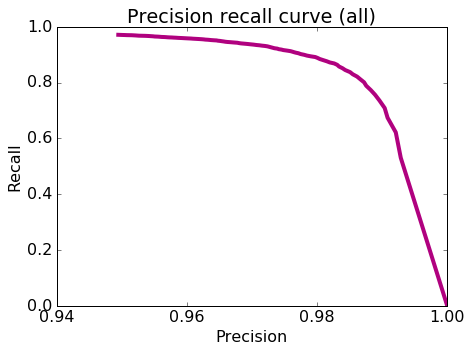

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

In [62]:
i = 0.98
predict_qn = np.array([1 if x >= i else -1 for x in probabilities])
precision_qn = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                                y_pred=predict_qn)
recall_qn = recall_score(y_true=test_data['sentiment'].to_numpy(),
                          y_pred=predict_qn)
cmat_qn = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=predict_qn,
                        labels=model.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat_qn[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  5048
     -1       |        1        |   193
      1       |       -1        |  8227
      1       |        1        | 19868


In [63]:
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

In [64]:
baby_reviews.head()

name,review,rating,sentiment,review_clean
"Baby Tracker&reg; - DailyChildcare Journal, ...",This has been an easy wayfor my nanny to record ...,4.0,1,This has been an easy wayfor my nanny to record ...
"Baby Tracker&reg; - DailyChildcare Journal, ...",I love this journal andour nanny uses it ...,4.0,1,I love this journal andour nanny uses it ...
Baby's First Year UndatedWall Calendar with ...,I searched high and lowfor a first year cale ...,5.0,1,I searched high and lowfor a first year cale ...
Our Baby Girl Memory Book,Absolutely love it andall of the Scripture in ...,5.0,1,Absolutely love it andall of the Scripture in ...
Newborn Baby Tracker&reg;- Round the Clock ...,This is the best way tokeep track of when your ...,5.0,1,This is the best way tokeep track of when your ...
"Large Jungle Animals(Panda, Lion, Elephant, ...",I ordered these for my 7month old sons play a ...,5.0,1,I ordered these for my 7month old sons play area ...
Sassy Who Loves Baby?Photo Album Book with ...,I bought this for a newgranddaughter. I will ...,5.0,1,I bought this for a newgranddaughter I will ...
Sassy Who Loves Baby?Photo Album Book with ...,"I originally bought thisfor my 4 month old son, ...",5.0,1,I originally bought thisfor my 4 month old son ...
Crown Crafts The OriginalNoJo BabySling by Dr. ...,This is a great productbut it is just too big ...,1.0,-1,This is a great productbut it is just too big ...
Crown Crafts The OriginalNoJo BabySling by Dr. ...,"I used this sling forboth of my babies, ...",5.0,1,I used this sling forboth of my babies 0gt ...


In [65]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

In [66]:
threshold_values = np.linspace(0.5, 1, num=100)

In [68]:
precision_all = []
recall_all = []
for i in threshold_values:
    predict = np.array([1 if x >= i else -1 for x in probabilities])
    precision = precision_score(y_true=baby_reviews['sentiment'].to_numpy(), 
                                y_pred=predict)
    recall = recall_score(y_true=baby_reviews['sentiment'].to_numpy(),
                          y_pred=predict)
    if precision > 0.96 and precision < 0.97:
        print(i,precision)
    precision_all.append(precision)
    recall_all.append(recall)

(0.65656565656565657, 0.96015424164524421)
(0.66161616161616166, 0.96064729680029426)
(0.66666666666666674, 0.96061832903938171)
(0.67171717171717171, 0.96112748710390572)
(0.6767676767676768, 0.96129032258064517)
(0.68181818181818188, 0.96142488002953119)
(0.68686868686868685, 0.96207215541165592)
(0.69191919191919193, 0.96292176492398962)
(0.69696969696969702, 0.96378157503714712)
(0.70202020202020199, 0.96374116772034213)
(0.70707070707070707, 0.96372093023255812)
(0.71212121212121215, 0.9640528962562861)
(0.71717171717171713, 0.96440551621319415)
(0.72222222222222221, 0.96437896307348003)
(0.72727272727272729, 0.96455885096064164)
(0.73232323232323238, 0.96598130841121499)
(0.73737373737373746, 0.96629844598389814)
(0.74242424242424243, 0.9673362117514549)
(0.74747474747474751, 0.967863183612103)
(0.7525252525252526, 0.96854398191749858)
(0.75757575757575757, 0.96870876531573991)
(0.76262626262626265, 0.96883264072534947)
(0.76767676767676774, 0.96898051825231701)
(0.77272727272727

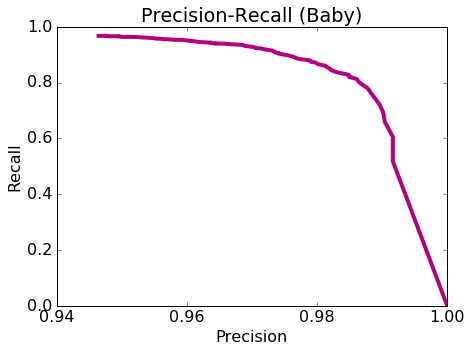

In [69]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")